# Projekt: Erkennung von Spurmarkierungen
In diesem Projekt sollen Spurmarkierungen in zwei bestehenden Datensätzen erkannt werden: 
1. Udacity Nanodegree "Self-Driving Car Engineer" (https://www.udacity.com/course/self-driving-car-engineer-nanodegree--nd0013)
2. KITTI-Datensatz zur Erkennung von Spurmarkierungen (http://www.cvlibs.net/datasets/kitti/eval_road.php)

In [1]:
import cv2 as cv
from matplotlib import pyplot as plt
import numpy as np
import os
import glob

In [2]:
def get_sample_image():
    return cv.cvtColor(cv.imread('./img/Udacity/image001.jpg'), cv.COLOR_BGR2RGB)

# Kamerakalibrierung
Die vorhandenen Bilder sind aufgrund der Linsen- und Kameraeigenschaften verzerrt. Entzerren Sie die Bilder mithilfe der Kamerakalibrierungsroutinen von OpenCV (https://docs.opencv.org/4.5.3/dc/dbb/tutorial_py_calibration.html) und den aufgezeichneten Bildern.

In [3]:
def calibrate_camera(images, nx, ny, show_corners=False):
    """Get camera calibration parameters from a set of images.

    Args:
        images (array of images): array of the images used to calibrate
        nx (int): number of chess corners in x direction
        ny (int): number of chess corners in y direction
        show_corners (bool, optional): show images with the corners included. Defaults to False.

    Returns:
        double: return values of cv.calibrateCamera
        ??: camera matrix
        ??: distortion coefficients
        ??: rotation vectors
        ??: translation vectors
    """
    # termination criteria
    criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 30, 0.001)

    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((ny*nx,3), np.float32)
    objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d point in real world space
    imgpoints = [] # 2d points in image plane.
    
    for fname in images:
        img = cv.imread(fname)
        gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

        # Find the chess board corners
        ret, corners = cv.findChessboardCorners(gray, (nx,ny), None)
        # If found, add object points, image points (after refining them)
        if ret == True:
            objpoints.append(objp)
            corners2 = cv.cornerSubPix(gray,corners, (11,11), (-1,-1), criteria)
            imgpoints.append(corners)
            # Draw and display the corners
            
            img_d = cv.drawChessboardCorners(img, (nx,ny), corners2, ret)
            if show_corners:
                plt.imshow(img_d)
                plt.title(fname)
                plt.show()

    ret, mtx, dist, rvecs, tvecs = cv.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    return ret, mtx, dist, rvecs, tvecs

In [4]:
images = glob.glob('./img/Udacity/calib/calibration*.jpg')
_, mtx, dist, rvecs, tvecs = calibrate_camera(images, 9, 6, show_corners=False)

# Undistort image
Hier wird das durch die Kamera verzerrte Bild, entzerrt

In [5]:
def undistort(image):
    return cv.undistort(image, mtx, dist, None, mtx)

#### Undistort single image

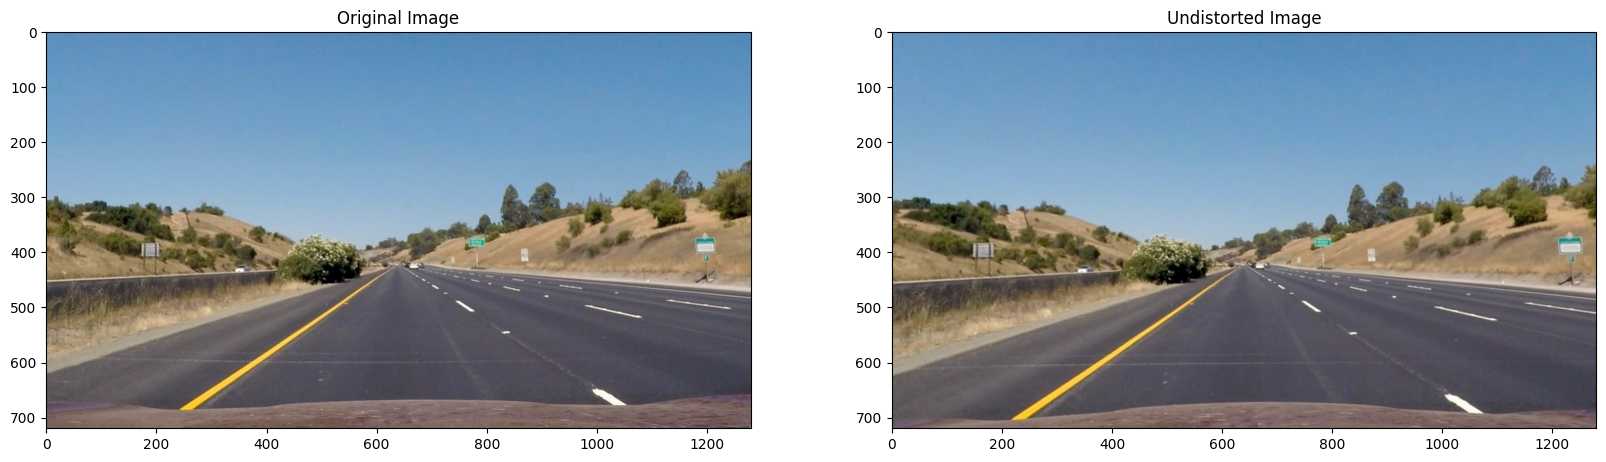

In [6]:
sample_image = get_sample_image()
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.imshow(sample_image)
plt.title('Original Image')

plt.subplot(1,2,2)
undistorted_image = undistort(sample_image)
plt.imshow(undistorted_image)
plt.title('Undistorted Image')
plt.show()

# Perspektivtransformation
Hier wird das reale Bild in ein Bird's Eye Bild der Straße transformiert

#### Warp method

In [7]:
def warp(image):
    """Warp the image to a bird's eye view.

    Args:
        image (image): image to be warped
    """
    img_size = (image.shape[1], image.shape[0]) # width x height
    offset = 300 # pixels
    src = np.float32([(701 ,459),  #top right
                      (1055,680),  #bottom right
                      (265 ,680),  #bottom left
                      (580 ,459)]) #top left

    # point array dst - destintation points close to source points in a rectangle
    
    dst = np.float32([(img_size[0]-offset,0), #top right
                      (img_size[0]-offset,img_size[1]), #bottom right
                      (img_size[0]-img_size[0]+offset,img_size[1]), #bottom left
                      (img_size[0]-img_size[0]+offset,0)]) #top left

    # use cv.getPerspectiveTransform() to get M, the transform matrix
    M = cv.getPerspectiveTransform(src, dst)
    
    # use.cv.getPerspectiveTransform() to get Minv, the inverse transform matrix
    Minv = cv.getPerspectiveTransform(dst, src)
    
    # use cv.warpPerspective() to warp your image to a top-down view
    warped = cv.warpPerspective(image, M, img_size)

    # TODO: wird das hier gebraucht?
    return warped #, M, Minv

#### Visualize Points used for transform

(1280, 720)


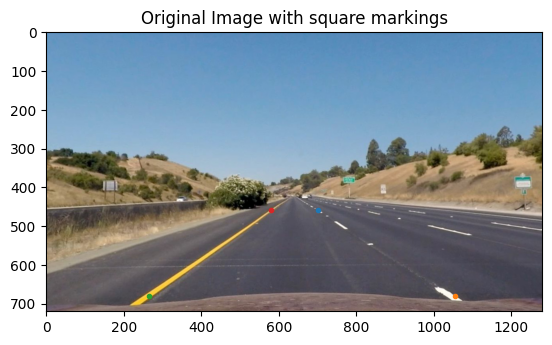

In [8]:
# verwendete Punkte visualisieren
sample = get_sample_image()
undistorted = undistort(sample)
img_size = (undistorted.shape[1], undistorted.shape[0]) # width x height

plt.imshow(undistorted)
plt.title('Original Image with square markings')
plt.plot(701,459, '.') #top right
plt.plot(1055,680, '.') #bottom right
plt.plot(265,680, '.') #bottom left
plt.plot(580,459, '.') #top left

print(img_size)

#### Warp Single Image

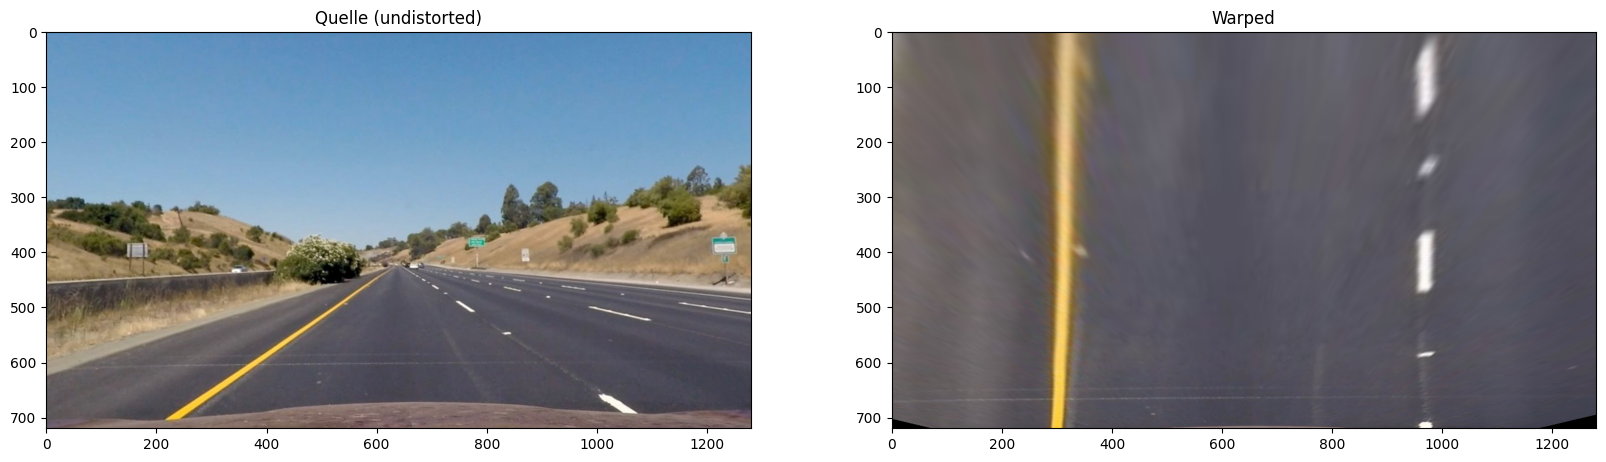

In [9]:
# einlesen eines Beispielbildes
sample = get_sample_image()
undistorted = undistort(sample)

plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.imshow(undistorted)
plt.title('Quelle (undistorted)')

warped  = warp(undistorted_image)

plt.subplot(1,2,2)
plt.imshow(warped)
plt.title('Warped')
plt.show()

# Filter for lane markings
Hier wird aus dem bird's eye view bild die Spurmarkierung rausgefiltert

In [10]:
def filter_lanes1(img):    
    hls = cv.cvtColor(img, cv.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    l_channel = hls[:,:,1]

    hsv = cv.cvtColor(img, cv.COLOR_RGB2HSV)
    v_channel = hsv[:,:,2]
    
    # Grayscale image
    # NOTE: we already saw that standard grayscaling lost color information for the lane lines
    # Explore gradients in other colors spaces / color channels to see what might work better
    gray = cv.cvtColor(img, cv.COLOR_RGB2GRAY)

    # Sobel x
    sobelx = cv.Sobel(gray, cv.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

    # Threshold x gradient
    thresh_min = 20
    thresh_max = 100
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    
    
    # Threshold color channel - saturation used to best detect lanes
    s_thresh_min = 115
    s_thresh_max = 255
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1
    
    # lightness threshold was used to better detect white lines
    l_thresh_min = 195
    l_thresh_max = 255
    l_binary = np.zeros_like(l_channel)
    l_binary[(l_channel >= l_thresh_min) & (l_channel <= l_thresh_max)] = 1
    
    # value threshold was used to better detect yellow lines
    v_thresh_min = 200
    v_thresh_max = 255
    v_binary = np.zeros_like(s_channel)
    v_binary[(v_channel >= v_thresh_min) & (v_channel <= v_thresh_max)] = 1

    # Stack each channel to view their individual contributions in green and blue respectively
    # This returns a stack of the two binary images, whose components you can see as different colors
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary))

    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 0.5) & (l_binary == 0.5)| (v_binary == 1) | (sxbinary == 1)] = 1

    return combined_binary

#### Filter in single image

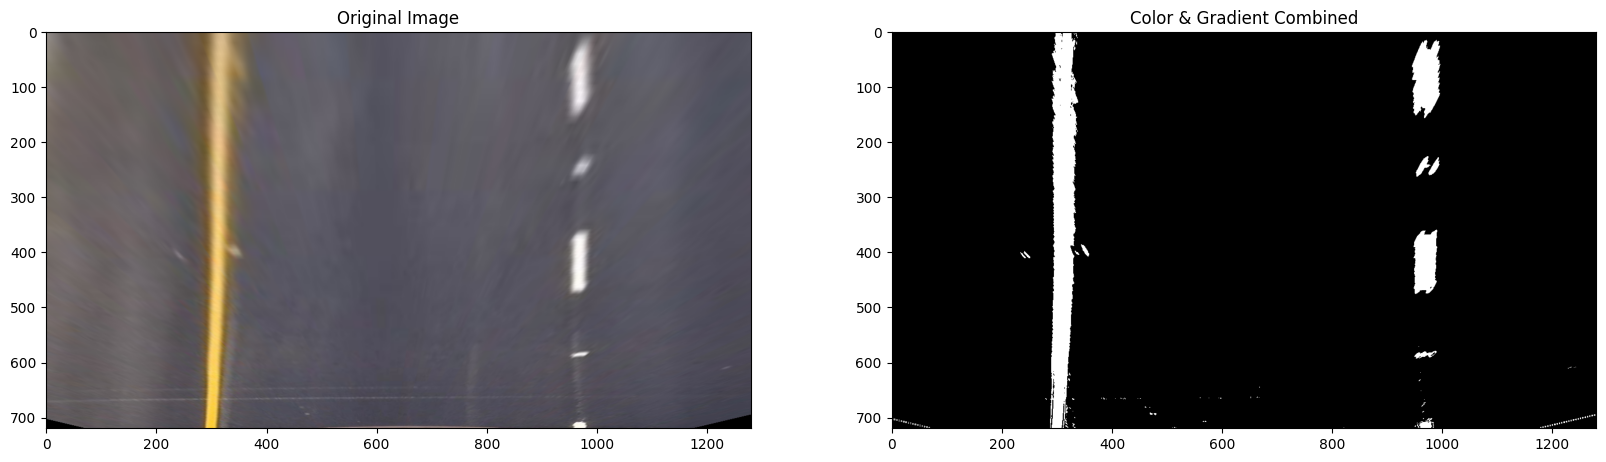

In [11]:
sample = get_sample_image()
undistorted = undistort(sample)
warped = warp(undistorted)

# Plot the result
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.imshow(warped)
plt.title('Original Image')


filtered = filter_lanes1(warped)

plt.subplot(1,2,2)
plt.imshow(filtered, cmap='gray')
plt.title('Color & Gradient Combined')
plt.show()

# Filter for lane markings v2
Hier wird aus dem bird's eye view bild die Spurmarkierung rausgefiltert

In [12]:
def extract_lab_color_spaces(uwimg):
    unwarped_LAB = cv.cvtColor(uwimg, cv.COLOR_RGB2Lab)
    unwarp_L = unwarped_LAB[:,:,0]
    unwarp_A = unwarped_LAB[:,:,1]
    unwarp_B = unwarped_LAB[:,:,2]
    
    return unwarp_L, unwarp_A,unwarp_B

# Extract H,S, and L color channels from HLS color space.
def extract_hls_color_spaces(uwimg):
    unwarp_HLS = cv.cvtColor(uwimg, cv.COLOR_RGB2HLS)
    unwarp_HLS_H = unwarp_HLS[:, :, 0]
    unwarp_HLS_L = unwarp_HLS[:, :, 1]
    unwarp_HLS_S = unwarp_HLS[:, :, 2]
    
    return unwarp_HLS_H,unwarp_HLS_L,unwarp_HLS_S

# Use exclusive lower bound (>) and inclusive upper (<=)
def hls_l_nomalize(img, thresh=(220, 255)):
    """
    This is used to nomalize HLS L color channel
    """
    # 1) Convert to HLS color space
    _,hls_l,_ = extract_hls_color_spaces(img)
    hls_l = hls_l*(255/np.max(hls_l))
    # 2) Apply a threshold to the L channel
    binary_output = np.zeros_like(hls_l)
    binary_output[(hls_l > thresh[0]) & (hls_l <= thresh[1])] = 1
    # 3) Return a binary image of threshold result
    return binary_output

def lab_b_nomalize(unwarped_img, thresh=(190,255)):
    """
    This is used to LAB B color channel
    """
    _,_,lab_b = extract_lab_color_spaces(unwarped_img)
    # don't normalize if there are no yellows in the image
    if np.max(lab_b) > 175:
        lab_b = lab_b*(255/np.max(lab_b))
    # 2) Apply a threshold to the L channel
    binary_output = np.zeros_like(lab_b)
    binary_output[((lab_b > thresh[0]) & (lab_b <= thresh[1]))] = 1
    # 3) Return a binary image of threshold result
    return binary_output

def filter_lanes2(image):
    # HLS L-channel Threshold (using default parameters)
    img_hls_L = hls_l_nomalize(image)

    # Lab B-channel Threshold (using default parameters)
    img_lab_B = lab_b_nomalize(image)
    
    # Combine HLS and Lab B channel thresholds
    combined = np.zeros_like(img_lab_B)
    combined[(img_hls_L == 1) | (img_lab_B == 1)] = 1
    
    return combined

#### Filter single image

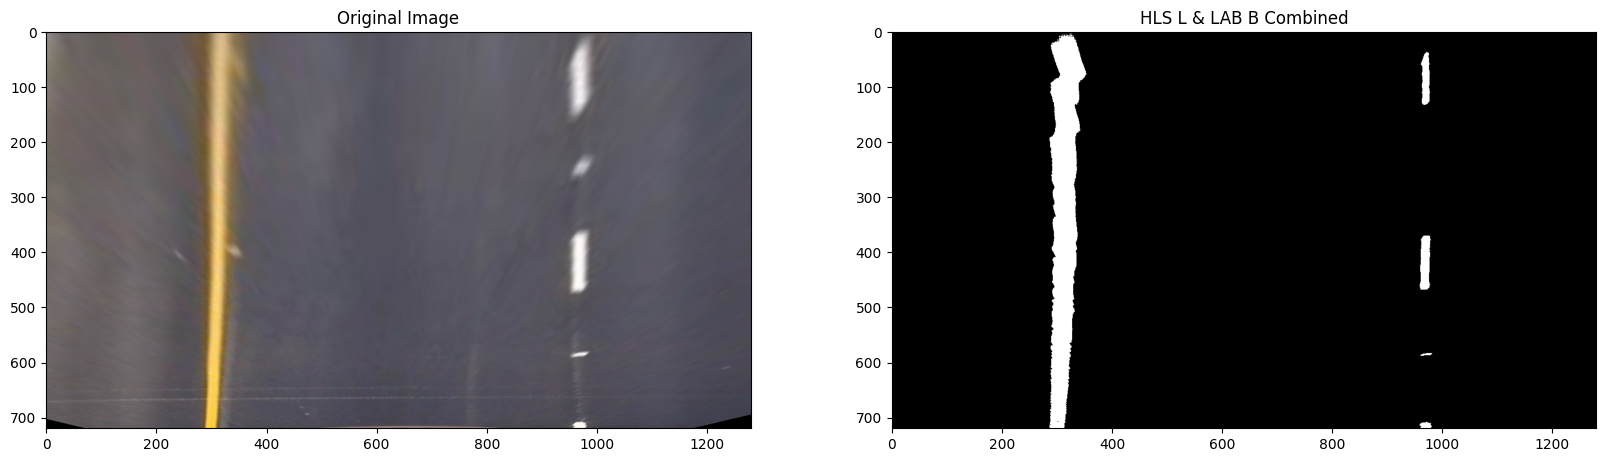

In [13]:
sample = get_sample_image()
undistorted = undistort(sample)
warped = warp(undistorted)

# Plot the result
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.imshow(warped)
plt.title('Original Image')


filtered = filter_lanes2(warped)

plt.subplot(1,2,2)
plt.imshow(filtered, cmap='gray')
plt.title('HLS L & LAB B Combined')
plt.show()

# Test with all images (v1 and v2)
Hier wird der Unterschied zwischen v1 und v2 im lane marking filter verglichen

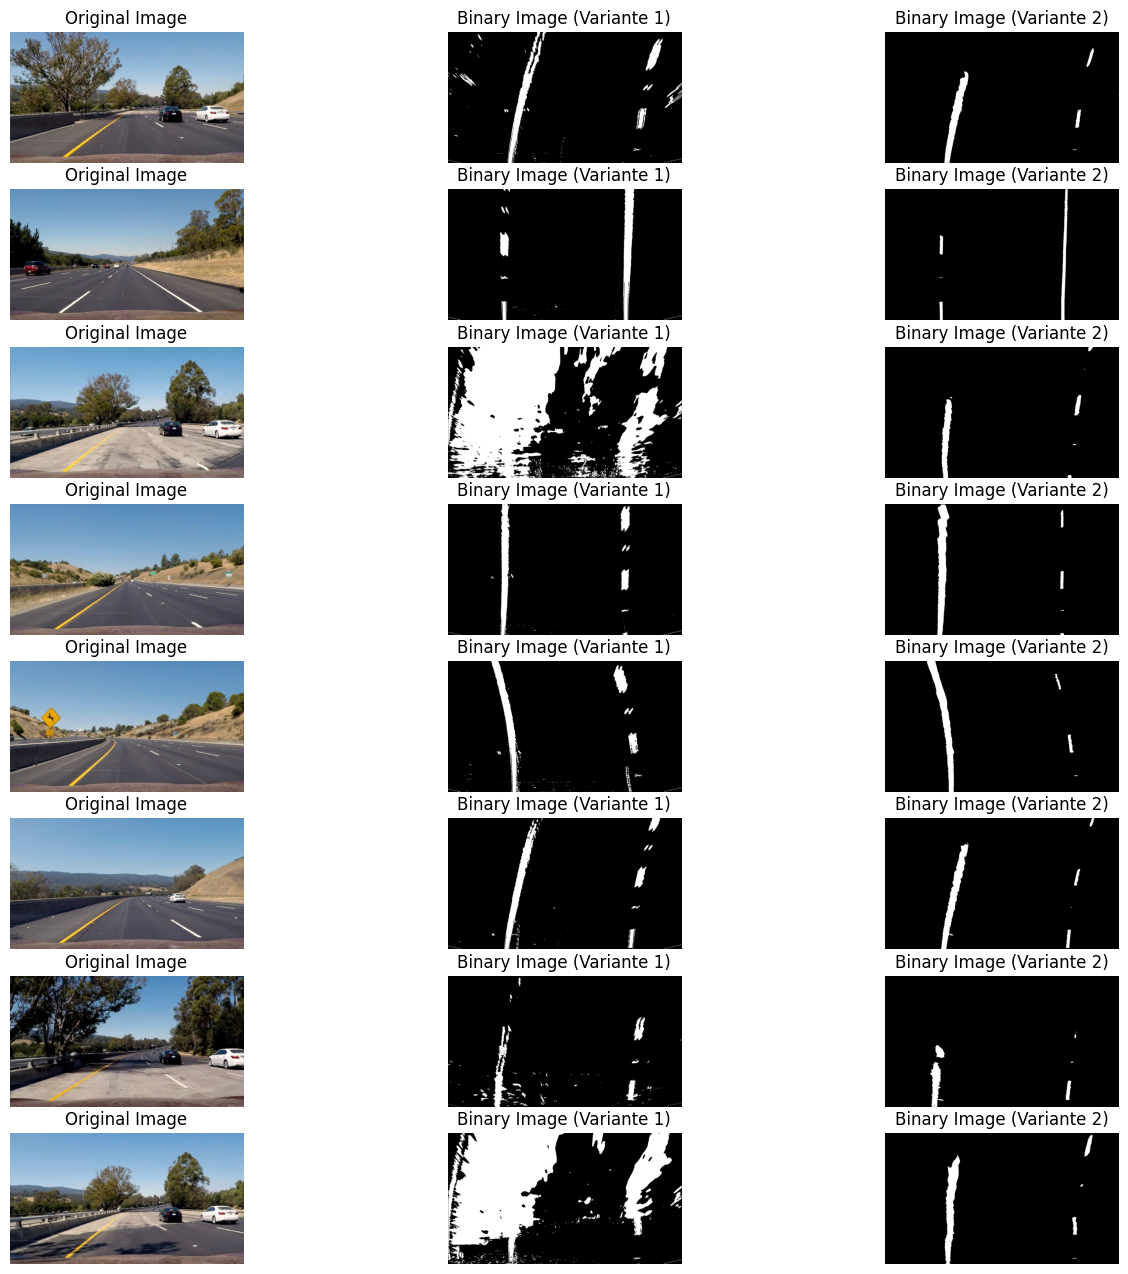

In [14]:
# Make a list of example images
images = glob.glob('./img/Udacity/*.jpg')
                                          
# Set up plot
fig, axs = plt.subplots(len(images),3, figsize=(16, 16))
# fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()
                  
i = 0
for image in images:
    img = cv.imread(image)
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    undistorted = undistort(img)
    warped = warp(undistorted)

    img_bin1 = filter_lanes1(warped)
    img_bin2 = filter_lanes2(warped)
    axs[i].imshow(img)
    axs[i].axis('off')
    axs[i].set_title("Original Image",fontsize=12)
    i += 1
    axs[i].imshow(img_bin1, cmap='gray')
    axs[i].axis('off')
    axs[i].set_title("Binary Image (Variante 1)",fontsize=12)
    i += 1
    axs[i].imshow(img_bin2, cmap='gray')
    axs[i].axis('off')
    axs[i].set_title("Binary Image (Variante 2)",fontsize=12)
    i += 1

# Curve fitting

## Histogram erstellen
Histogram der unteren Hälfte vom Bild nehmen. Hier muss es zwei peaks von weiß geben. Der Start der Linken und der rechten Markierung

In [15]:
def hist(img):
    """
    This is used to extract data points for a histogram
    """
    # Grab only the bottom half of the image

    bottom_half = img[img.shape[0]//4:,:]

    # Sum across image pixels vertically - make sure to set an `axis`
    # i.e. the highest areas of vertical lines should be larger values
    histogram = np.sum(bottom_half, axis=0)
    
    return histogram

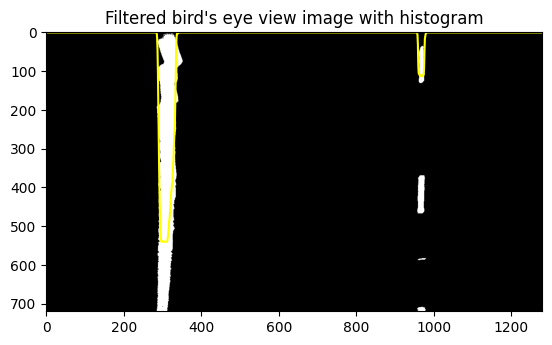

In [16]:
sample = get_sample_image()
undistorted = undistort(sample)
warped = warp(undistorted)
filtered = filter_lanes2(warped)
histogram = hist(filtered)


plt.imshow(filtered, cmap='gray')
plt.plot(histogram, color='yellow')
plt.title("Filtered bird's eye view image with histogram")
plt.show()

## Peaks in Histogram herausfinden

In [17]:
def find_peaks(histogram):
    midpoint = int(histogram.shape[0]//2)
    quarter_point = int(midpoint//2)
    # Previously the left/right base was the max of the left/right half of the histogram
    # this changes it so that only a quarter of the histogram (directly to the left/right) is considered
    leftx_base = np.argmax(histogram[quarter_point:midpoint]) + quarter_point
    rightx_base = np.argmax(histogram[midpoint:(midpoint+quarter_point)]) + midpoint
    return leftx_base, rightx_base

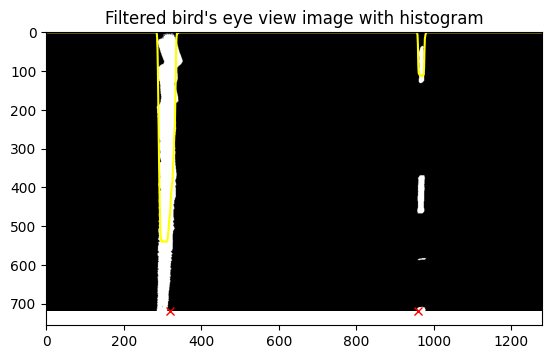

In [18]:
sample = get_sample_image()
undistorted = undistort(sample)
warped = warp(undistorted)
filtered = filter_lanes2(warped)
histogram = hist(filtered)
l_peak, r_peak = find_peaks(histogram)

height = filtered.shape[0]

plt.imshow(filtered, cmap='gray')
plt.plot(histogram, color='yellow')
plt.plot(l_peak, height, 'x', color='red')
plt.plot(r_peak, height, 'x', color='red')
plt.title("Filtered bird's eye view image with histogram")
plt.show()

# Komplette Pipeline
Hier ist die Definition der kompletten Verarbeitungspipeline für jedes Frame im Video

In [23]:
def pipeline(image):
    # undistort
    undistorted = undistort(image)
    # plt.imshow(undistorted)
    # plt.show()

    # Persfective transform
    warped = warp(undistorted)
    # plt.imshow(warped)
    # plt.show()

    # Filter lanes
    filtered = filter_lanes2(warped)
    # plt.imshow(converted)
    # plt.show()

    # Kurze einzeichnen

    # Fläche markieren

    # zurück-warpen

    # TODO: change return value
    return warped

# Timing
Hier wird getestet, wie schnell die Verarbeitung für ein Frame ist

Frametime:  0.036195993423461914
est. FPS:  27.62736715914555


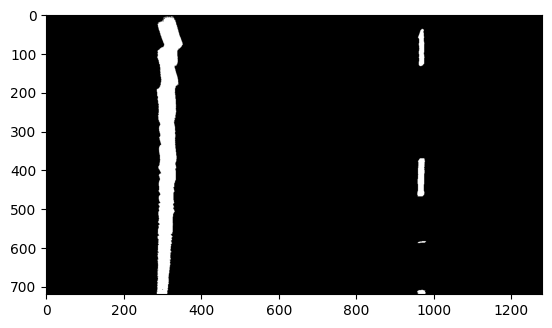

In [20]:
import time

sample = get_sample_image()

start = time.time()

result = pipeline(sample)

diff = time.time() - start

print('Frametime: ', diff)
print('est. FPS: ', 1/diff)

plt.imshow(result, cmap='gray')
plt.show()

# Video-Verarbeitung

In [21]:
# from moviepy.editor import VideoFileClip
# from IPython.display import HTML
# output = 'output.mp4'
# clip1 = VideoFileClip("./img/Udacity/project_video.mp4")#.subclip(26,35)
# test_clip = clip1.fl_image(findlane) #NOTE: this function expects color images!!
# %time test_clip.write_videofile(output, audio=False)

In [24]:
cap = cv.VideoCapture('img/Udacity/project_video.mp4')
 
# Check if camera opened successfully
if (cap.isOpened()== False): 
  print("Error opening video stream or file")
 
# Read until video is completed
while(cap.isOpened()):
  # Capture frame-by-frame
  ret, frame = cap.read()
  if ret == True:
    cv.startWindowThread()

    output = pipeline(frame)
 
    # Display the resulting frame
    cv.imshow('Frame',output)
 
    # Press Q on keyboard to  exit
    if cv.waitKey(25) & 0xFF == ord('q'):
      break
 
  # Break the loop
  else: 
    break
 
# When everything done, release the video capture object
cap.release()
 
# Closes all the frames
cv.destroyAllWindows()
cv.waitKey(1)

-1